In [32]:
import eispac
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
import pandas as pd
import os
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.constants as const
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import shapely
from scipy.io import readsav
import scipy.interpolate
from astropy.visualization import (ImageNormalize, SqrtStretch, 
                                   AsinhStretch, LogStretch)
from eis_straylight import calc_short_range_stray_light, calc_long_range_stray_light_aia_eis, coalign_eis_aia
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator
import cmcrameri.cm as cmcm
import corner
import bottleneck as bn

In [2]:
aia_131_map = sunpy.map.Map('../../src/AIA/20221025/131/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.131.image.fits')
aia_171_map = sunpy.map.Map('../../src/AIA/20221025/171/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.171.image.fits')
aia_193_map = sunpy.map.Map('../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.193.image.fits')
aia_211_map = sunpy.map.Map('../../src/AIA/20221025/211/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.211.image.fits')
aia_335_map = sunpy.map.Map('../../src/AIA/20221025/335/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.335.image.fits')
aia_94_map = sunpy.map.Map('../../src/AIA/20221025/94/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.94.image.fits')

In [3]:
eis_file_prefix = '../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.'

In [4]:
eis_FeXII_195_fitres = eispac.read_fit(eis_file_prefix + 'fe_12_195_119.1c-0.fit.h5')
eis_FeXII_195_intmap = eis_FeXII_195_fitres.get_map(component=0, measurement='intensity')
eis_FeXII_195_velmap = eis_FeXII_195_fitres.get_map(component=0, measurement='velocity')
eis_FeXII_195_widmap = eis_FeXII_195_fitres.get_map(component=0, measurement='width')

Txshift_aia_eis_rough, Tyshift_aia_eis_rough = coalign_eis_aia(eis_FeXII_195_intmap, aia_193_map)
eis_FeXII_195_intmap = eis_FeXII_195_intmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)
eis_FeXII_195_velmap = eis_FeXII_195_velmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)
eis_FeXII_195_widmap = eis_FeXII_195_widmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)

c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value

FeXII_195_true_width_fwhm = np.sqrt((eis_FeXII_195_widmap.data * np.sqrt(8*np.log(2)))**2 - \
                                    eis_FeXII_195_fitres.meta["slit_width"][:,np.newaxis]**2)
FeXII_195_v1oe = FeXII_195_true_width_fwhm/np.sqrt(4*np.log(2))*c/195.119
FeXII_195_vth2 = 2*k_B*10**6.25/amu/55.85
FeXII_195_vnth = np.sqrt(FeXII_195_v1oe**2 - FeXII_195_vth2)
eis_FeXII_195_vnthmap = sunpy.map.Map(FeXII_195_vnth/1e5, eis_FeXII_195_widmap.meta)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_448722/2815883421.py:15: RuntimeWarning: invalid value encountered in sqrt
  FeXII_195_true_width_fwhm = np.sqrt((eis_FeXII_195_widmap.data * np.sqrt(8*np.log(2)))**2 - \
/tmp/ipykernel_448722/2815883421.py:19: RuntimeWarning: invalid value encountered in sqrt
  FeXII_195_vnth = np.sqrt(FeXII_195_v1oe**2 - FeXII_195_vth2)


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


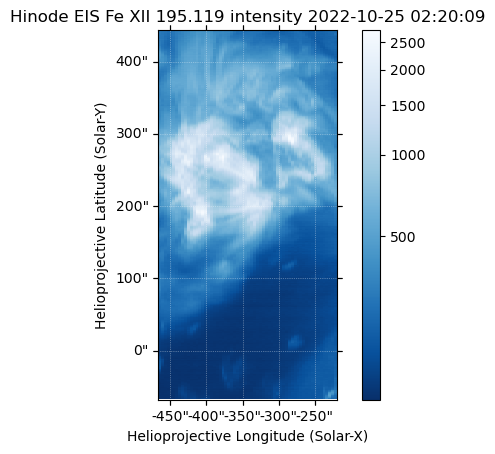

In [5]:
eis_FeXII_195_intmap.plot()
plt.colorbar()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(150.0, 350.0)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations small

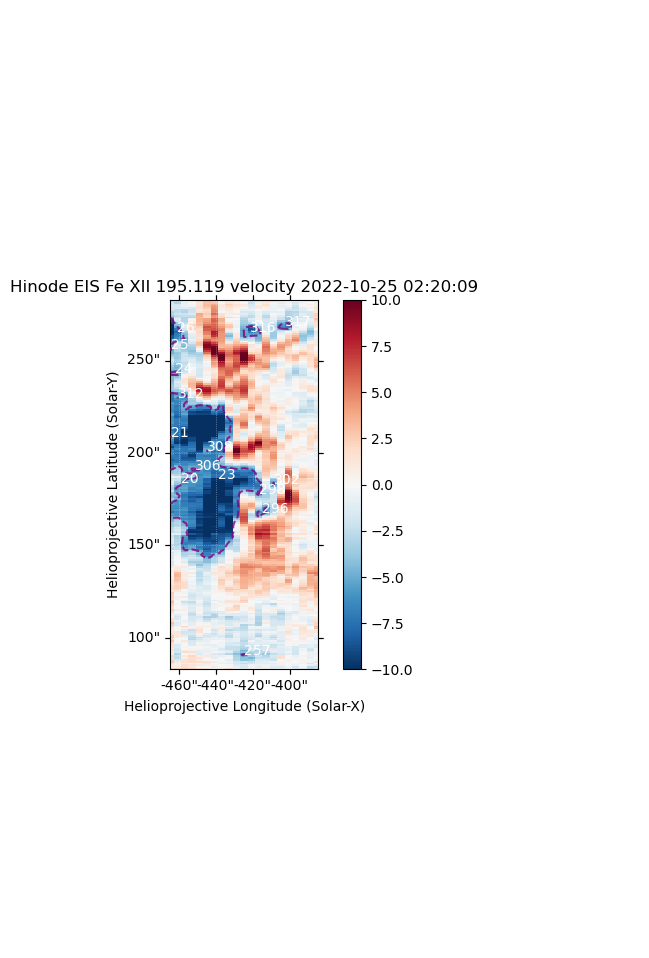

In [6]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap)
eis_FeXII_195_velmap.plot(axes=ax)

cs = eis_FeXII_195_velmap.draw_contours(levels=[-5,]*eis_FeXII_195_velmap.unit,colors=["purple"],axes=ax,alpha=0.8)
plt.colorbar()

for ii, seg in enumerate(cs.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

ax.set_xlim(0,20)
ax.set_ylim(150,350)

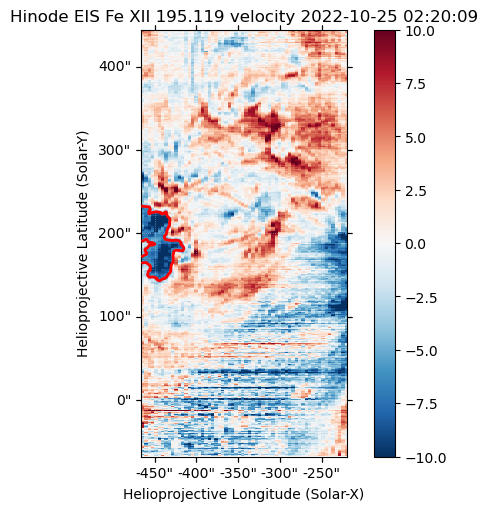

In [7]:
cs_selected_index = [20,23]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap)
eis_FeXII_195_velmap.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index:
    ax.plot(*cs.allsegs[0][ii].T, color='red', lw=2)

In [8]:
cs_skycoords = [eis_FeXII_195_velmap.pixel_to_world(np.concatenate((cs.allsegs[0][cs_selected_index[0]][:,0],
                                                                    cs.allsegs[0][cs_selected_index[1]][:,0]))*u.pix,
                                                    np.concatenate((cs.allsegs[0][cs_selected_index[0]][:,1],
                                                                    cs.allsegs[0][cs_selected_index[1]][:,1]))*u.pix) \
                ]
cs_regions = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords]

In [9]:
def get_profiles_from_regions(datacube, intensity_map, regions, wavelengths):
    masks = [np.where(cs_region.contains(sunpy.map.all_coordinates_from_map(intensity_map), 
                                                intensity_map.wcs)) for cs_region in cs_regions]
    profiles = [datacube.data[mask_] for mask_ in masks]
    wavelengths_masked = [wavelengths[mask_] for mask_ in masks]
    return profiles, wavelengths_masked

In [64]:
def plot_cs_profiles(eis_line_name,cs_regions, plot_index=0, 
                      component=0, wmin=-0.15, wmax=0.15):

    eis_wavelength = int(eis_line_name.split('_')[2]) + 1e-3*int(eis_line_name.split('_')[3][:3])
    datacube = eispac.read_cube(eis_file_prefix+'data.h5', eis_wavelength)

    eis_fitres = eispac.read_fit(eis_file_prefix + eis_line_name + '.fit.h5')
    eis_intmap = eis_fitres.get_map(component=component, measurement='intensity')
    eis_intmap = eis_intmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)

    profiles, wavelength_masked = get_profiles_from_regions(datacube, eis_intmap, cs_regions, datacube.wavelength)
    profiles = [profile_/np.nanmax(profile_, axis=1)[:, np.newaxis] for profile_ in profiles]
    print(profiles[plot_index].shape)   

    fig, ax = plt.subplots(layout='constrained')

    for ii in range(profiles[plot_index].shape[0]):
        ax.step(wavelength_masked[plot_index][ii,:], profiles[plot_index][ii,:], where='mid',
                color='Gray', alpha=0.1,lw=0.5)
    
    ax.set_xlim(eis_wavelength+wmin, eis_wavelength+wmax)


Data file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.data.h5
Header file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.head.h5
Found a wavelength 195.12 [Angstroms] in window 8
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
(615, 24)


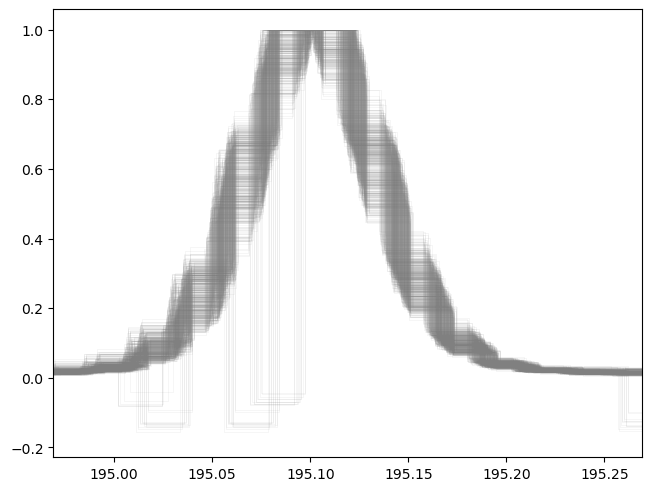

In [65]:
plot_cs_profiles('fe_12_195_119.1c-0', cs_regions, plot_index=0)

In [89]:
def calculate_rbp(wavelength, profile, uc=90*u.km/u.s, half_deltau=30*u.km/u.s, return_all=False):
    wavelength_interp = np.linspace(wavelength.min(), wavelength.max(), len(wavelength)*10)
    profile_interp_func = scipy.interpolate.CubicSpline(wavelength, profile)
    profile_interp = profile_interp_func(wavelength_interp)

    centroid_index = np.nanargmax(profile_interp)
    centroid_wvl = wavelength_interp[centroid_index]
    window_wvl = (u.Quantity([-half_deltau, half_deltau])/const.c).decompose()*centroid_wvl
    shift_wvl = (uc/const.c).decompose()*centroid_wvl
    blue_window_wvl = centroid_wvl - shift_wvl + window_wvl
    red_window_wvl = centroid_wvl + shift_wvl + window_wvl

    blue_window_index = np.where((wavelength_interp > blue_window_wvl[0]) & (wavelength_interp < blue_window_wvl[1]))
    red_window_index = np.where((wavelength_interp > red_window_wvl[0]) & (wavelength_interp < red_window_wvl[1]))

    blue_window_int = np.trapz(profile_interp[blue_window_index], wavelength_interp[blue_window_index])/len(blue_window_index)*len(red_window_index)
    red_window_int = np.trapz(profile_interp[red_window_index], wavelength_interp[red_window_index])

    if return_all:
        return blue_window_int, red_window_int, blue_window_index, red_window_index, wavelength_interp, profile_interp
    return red_window_int - blue_window_int

In [119]:
def calculate_rbp_map(eis_line_name, uc=90*u.km/u.s, half_deltau=30*u.km/u.s, component=0, xbin=1, ybin=1):
    eis_wavelength = int(eis_line_name.split('_')[2]) + 1e-3*int(eis_line_name.split('_')[3][:3])
    datacube = eispac.read_cube(eis_file_prefix+'data.h5', eis_wavelength)

    eis_fitres = eispac.read_fit(eis_file_prefix + eis_line_name + '.fit.h5')
    eis_intmap = eis_fitres.get_map(component=component, measurement='intensity')
    eis_intmap = eis_intmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)

    datacube_data = datacube.data.copy()
    datacube_data[datacube_data < 0] = np.nan

    datacube_data = bn.move_mean(datacube_data, window=ybin, axis=0, min_count=1)
    datacube_data = bn.move_mean(datacube_data, window=xbin, axis=1, min_count=1)

    rbs_map = np.zeros_like(eis_intmap.data)
    for idy in range(eis_intmap.data.shape[0]):
        for idx in range(eis_intmap.data.shape[1]):
            wavelength_mask = np.where((datacube.wavelength[idy,idx,:] > eis_wavelength - 0.15) & (datacube.wavelength[idy,idx,:] < eis_wavelength + 0.15))
            wavelength_ = datacube.wavelength[idy,idx,wavelength_mask].reshape(-1)
            data_ = datacube_data[idy, idx,wavelength_mask].reshape(-1)/np.nanmax(datacube_data[idy, idx,wavelength_mask])
            nan_index_ = np.isnan(data_)
            wavelength_ = wavelength_[~nan_index_]
            data_ = data_[~nan_index_]

            rbs_map[idy,idx] = calculate_rbp(wavelength_, data_, uc=uc, half_deltau=half_deltau)

    return sunpy.map.Map(rbs_map*0.022*3e5/eis_wavelength, eis_intmap.meta)

In [120]:
eis_cube = eispac.read_cube(eis_file_prefix+'data.h5', 195.119)
test_profile = eis_cube.data[250,30,:]
test_wvl = eis_cube.wavelength[250,30,:]
test_wvl_mask = np.where((test_wvl > 195.119 - 0.15) & (test_wvl < 195.119 + 0.15))
test_profile = test_profile[test_wvl_mask]
test_wvl = test_wvl[test_wvl_mask]

Data file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.data.h5
Header file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.head.h5
Found a wavelength 195.12 [Angstroms] in window 8
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [121]:
(blue_window_int_test, red_window_int_test, blue_window_index_test,
red_window_index_test, wavelength_interp_test, profile_interp_test) = calculate_rbp(test_wvl, test_profile/np.nanmax(test_profile), return_all=True)

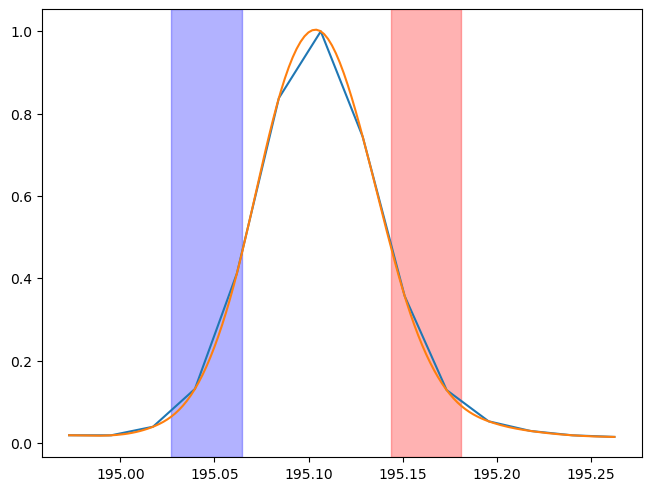

In [122]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(test_wvl, test_profile/np.nanmax(test_profile))
ax.plot(wavelength_interp_test, profile_interp_test)
ax.axvspan(wavelength_interp_test[blue_window_index_test][0], wavelength_interp_test[blue_window_index_test][-1], color='blue', alpha=0.3)
ax.axvspan(wavelength_interp_test[red_window_index_test][0], wavelength_interp_test[red_window_index_test][-1], color='red', alpha=0.3)

In [123]:
eis_FeXII_195_rbpmap = calculate_rbp_map('fe_12_195_119.1c-0')
eis_FeXII_195_rbpmap_corr = sunpy.map.Map(eis_FeXII_195_rbpmap.data - np.nanmedian(eis_FeXII_195_rbpmap.data), eis_FeXII_195_rbpmap.meta)

Data file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.data.h5
Header file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.head.h5
Found a wavelength 195.12 [Angstroms] in window 8
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


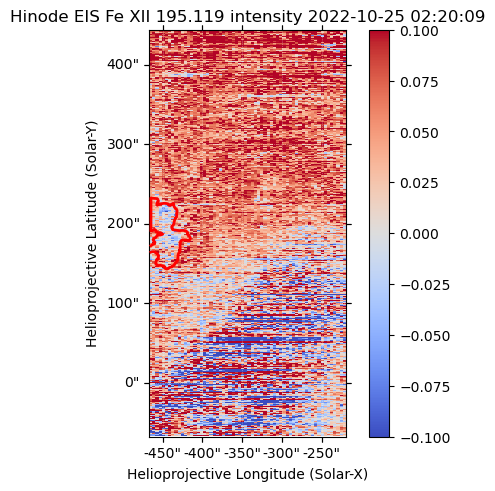

In [124]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_rbpmap)
eis_FeXII_195_rbpmap.plot(axes=ax, norm=ImageNormalize(vmin=-0.1,vmax=0.1),
                          cmap='coolwarm')
plt.colorbar()
ax.plot_coord(cs_regions[0].vertices, color='red', lw=2, label='Upflow Region' if ii == 0 else '')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


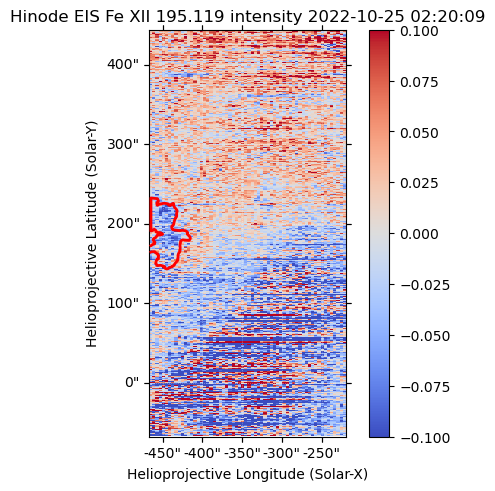

In [125]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_rbpmap_corr)
eis_FeXII_195_rbpmap_corr.plot(axes=ax, norm=ImageNormalize(vmin=-0.1,vmax=0.1),
                          cmap='coolwarm')
plt.colorbar()
ax.plot_coord(cs_regions[0].vertices, color='red', lw=2, label='Upflow Region' if ii == 0 else '')

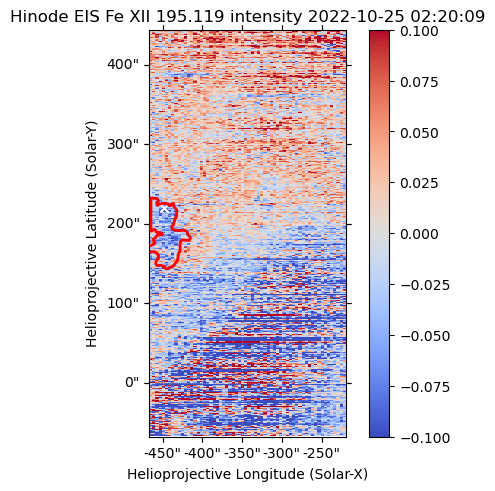

In [126]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_rbpmap_corr)
eis_FeXII_195_rbpmap_corr.plot(axes=ax, norm=ImageNormalize(vmin=-0.1,vmax=0.1),
                          cmap='coolwarm')
plt.colorbar()
ax.plot_coord(cs_regions[0].vertices, color='red', lw=2, label='Upflow Region' if ii == 0 else '')
ax.scatter(4,287,marker='x',color='white')

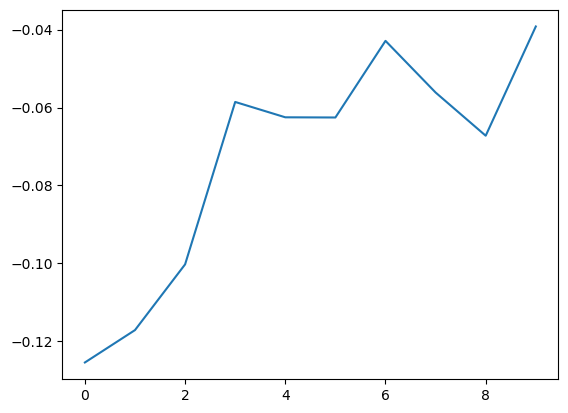

In [127]:
plt.plot(eis_FeXII_195_rbpmap_corr.data[285:295,4])

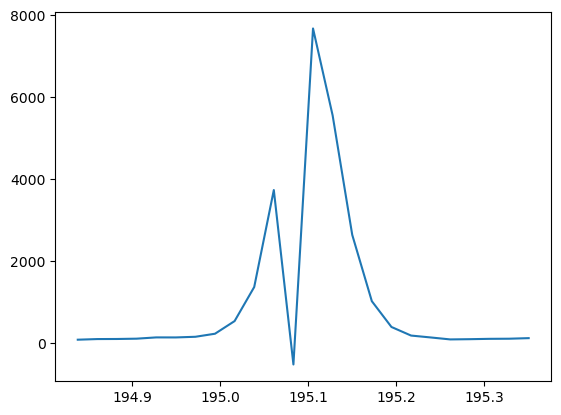

In [128]:
plt.plot(eis_cube.wavelength[290,4,:], eis_cube.data[290,4,:])

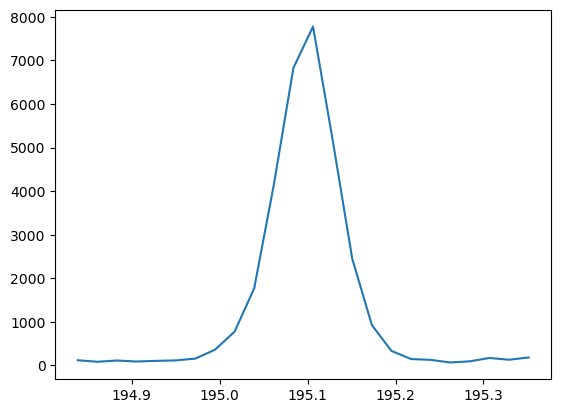

In [129]:
plt.plot(eis_cube.wavelength[285,4,:], eis_cube.data[285,4,:])

In [130]:
eis_FeXIII_202_rbpmap = calculate_rbp_map('fe_13_202_044.1c-0', xbin=2, ybin=4)

Data file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.data.h5
Header file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.head.h5
Found a wavelength 202.04 [Angstroms] in window 11
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_13_202_044.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


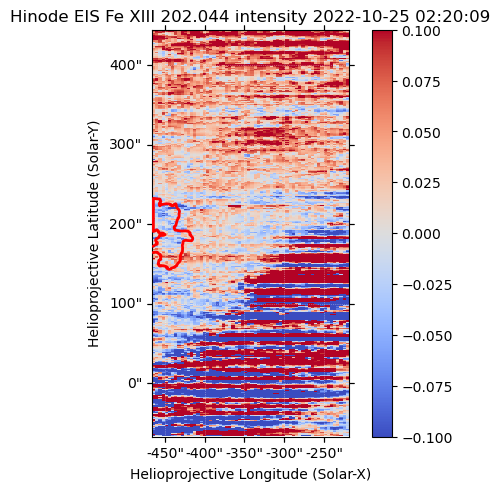

In [131]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXIII_202_rbpmap)
eis_FeXIII_202_rbpmap.plot(axes=ax, norm=ImageNormalize(vmin=-0.1,vmax=0.1),
                          cmap='coolwarm')
plt.colorbar()
ax.plot_coord(cs_regions[0].vertices, color='red', lw=2, label='Upflow Region' if ii == 0 else '')

In [132]:
eis_FeXIV_264_rbpmap = calculate_rbp_map('fe_14_264_787.1c-0', xbin=2, ybin=4)

Data file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.data.h5
Header file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.head.h5
Found a wavelength 264.79 [Angstroms] in window 18
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_14_264_787.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


Data file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.data.h5
Header file,
   /home/yjzhu/Solar/EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.head.h5
Found a wavelength 264.79 [Angstroms] in window 18
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_14_264_787.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
(616, 72)


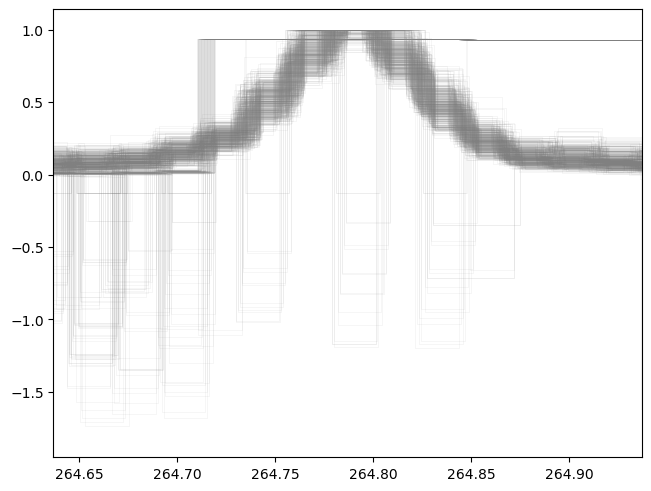

In [133]:
plot_cs_profiles('fe_14_264_787.1c-0', cs_regions, plot_index=0)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


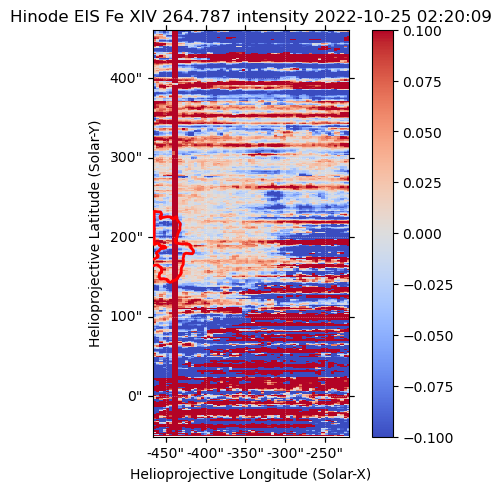

In [134]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXIV_264_rbpmap)
eis_FeXIV_264_rbpmap.plot(axes=ax, norm=ImageNormalize(vmin=-0.1,vmax=0.1),
                          cmap='coolwarm')
plt.colorbar()
ax.plot_coord(cs_regions[0].vertices, color='red', lw=2, label='Upflow Region' if ii == 0 else '')